<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [2]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn 
import help_functions as hf

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

plt.rcParams["font.family"] = "Times New Roman"

In [3]:
# Parameters to adapt

run_path = '../../data/runs_01_2025/'
unique_model_description = "wannabe_best_6/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'
result_path = '../../data/results/results_01_2025/'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
gdf_edges_with_districts = gpd.sjoin(links_base_case, districts, how='left', op='intersects')

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)
loss_fct_mae = torch.nn.L1Loss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - GATConv(512, 64, heads=1): x, edge_in

In [5]:
# len(test_set_loader.dataset)

In [6]:
# test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

# print(f"Test Loss: {test_loss}")
# print(f"R-squared: {r_squared}")
# print(f"Baseline Loss: {baseline_loss}")



# Next, we will look at single elements of the test set and visualize the performance of the model.


In [7]:
# fixed_norm_max = 50

# for i in range(50):
#     if i != 2 and i != 12 and i != 16:
#         continue
#     my_test_data = test_set_loader.dataset[i]
#     my_test_x = test_set_loader.dataset[i].x
#     my_test_x = my_test_x.to('cpu')
    
#     test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
#     print(f"Test {i}")
#     print(f"Test Loss: {test_loss_my_test_data}")
#     print(f"R-squared: {r_squared_my_test_data}")
#     print(f"Baseline Loss: {baseline_loss_my_test_data}")

#     inversed_x = scaler_x.inverse_transform(my_test_x)

#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
#     # gdf_with_og_values['district'] = gdf_with_og_values.apply(
#     # lambda row: districts[districts.contains(row.geometry)].iloc[0]['c_ar'] if not districts[districts.contains(row.geometry)].empty else 'Unknown',
#     # axis=1
#     gdf_with_og_values = gpd.sjoin(gdf_with_og_values, districts, how='left', op='intersects')

#     # hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
#     #                         save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
#     #                         fixed_norm_max = fixed_norm_max,
#     #                         known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path, with_legend=False)
#     # hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
#     #                         number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
#     #                         fixed_norm_max = fixed_norm_max,
#     #                         known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path, with_legend=False)

In [8]:
# Generalize the creation of gdfs for a range of indices
gdfs = []
for i in range(len(test_set_loader.dataset)):
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    inversed_x = scaler_x.inverse_transform(my_test_x)
    gdf = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf = gpd.sjoin(gdf, districts, how='left', op='intersects')
    gdf = gdf.rename(columns={"c_ar": "district"})
    gdf['capacity_reduction_rounded'] = gdf['capacity_reduction'].round(decimals=3)
    gdf['highway'] = gdf['highway'].map(hf.highway_mapping)
    gdfs.append(gdf)
    
# fixed_norm_max = 50

# for i in range(100):
#     if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
#         continue
#     my_test_data = test_set_loader.dataset[i]
#     my_test_x = test_set_loader.dataset[i].x
#     my_test_x = my_test_x.to('cpu')
    
#     test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
#     print(f"Test {i}")
#     print(f"Test Loss: {test_loss_my_test_data}")
#     print(f"R-squared: {r_squared_my_test_data}")
#     print(f"Baseline Loss: {baseline_loss_my_test_data}")

#     inversed_x = scaler_x.inverse_transform(my_test_x)

#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
#                             number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is de

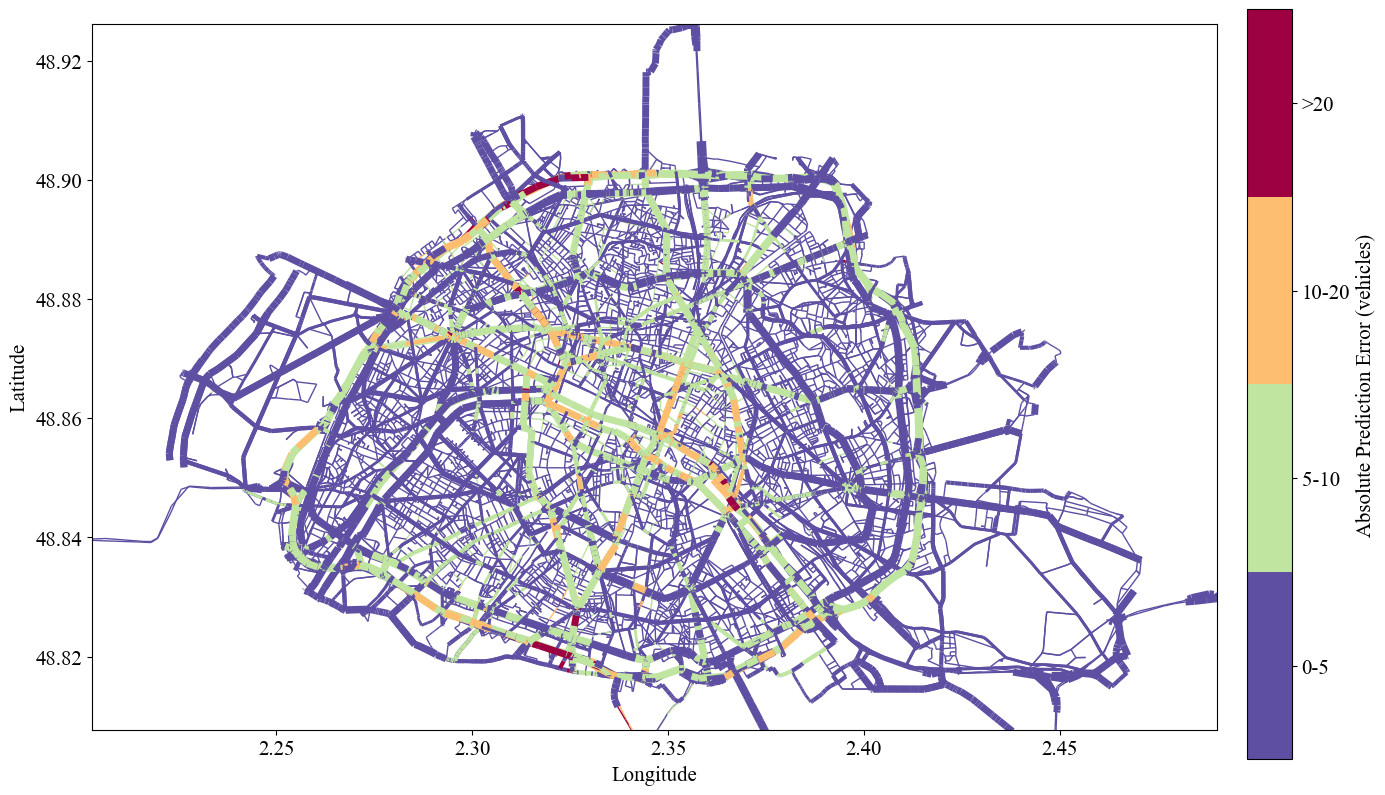

In [9]:
result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(5, 10, 20),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=False,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="l1",
    error_threshold=20,
    cmap = 'Spectral_r'
)

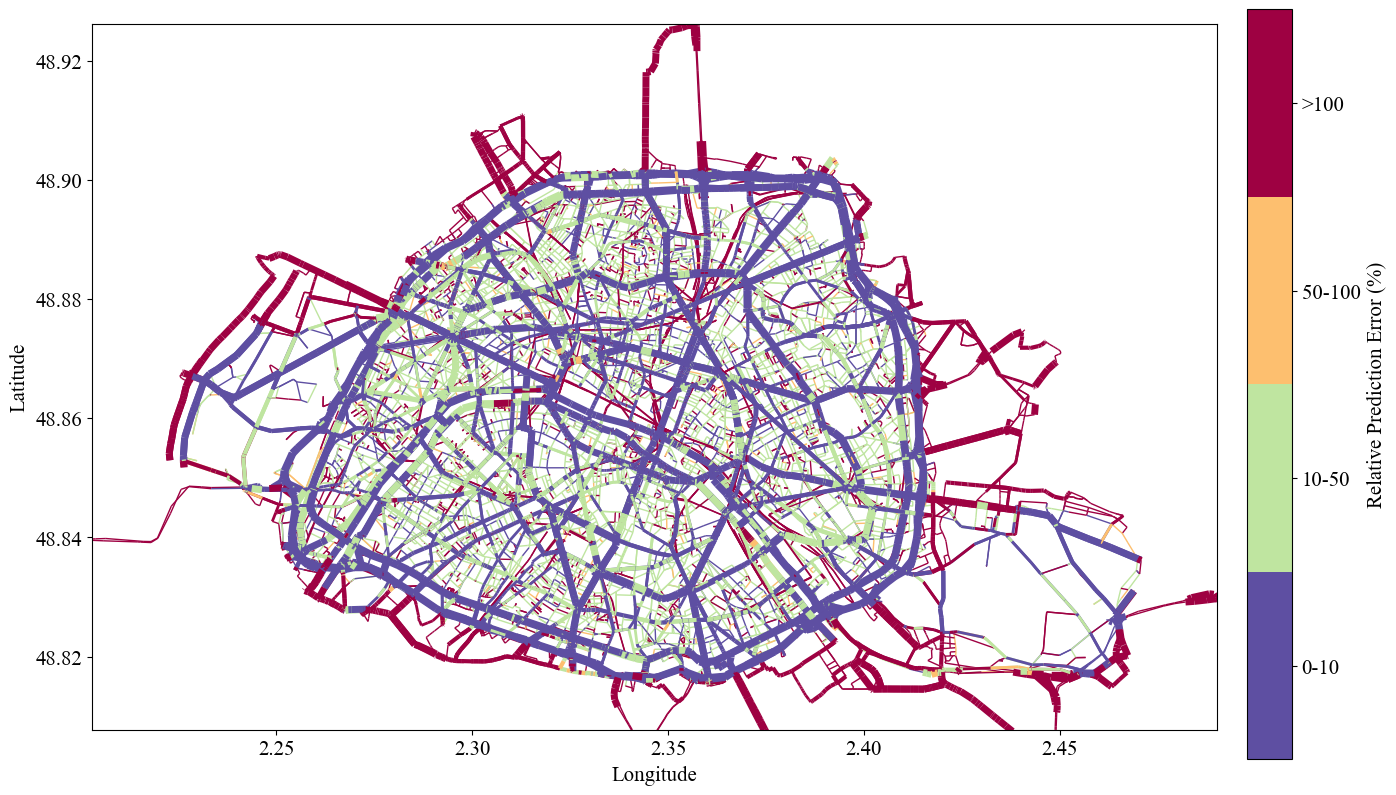

In [10]:
# For absolute differences in number of vehicles


result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(10, 50, 100),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=True,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="l1",
    error_threshold=100,
    cmap = 'Spectral_r'
)

### District analysis
Do all districts appear with the same frequency in the test set? This is investigated below.


District Statistics (sorted by selection frequency):
      mean_volume   total_volume  volume_variance  n_roads  \
1.0     42.958685   22553.309524      4946.819778    525.0   
10.0    39.501100   40172.619048      3052.238701   1017.0   
6.0     37.029622   30031.023810      2538.089723    811.0   
3.0     54.624066   23324.476190      5136.456899    427.0   
8.0     63.110064   81285.761905     11131.197236   1288.0   
9.0     36.609444   30678.714286      2522.593129    838.0   
11.0    32.381705   39959.023810      1833.699532   1234.0   
12.0    75.539321  189226.000000     34820.227748   2505.0   
7.0     33.245639   41025.119048      2969.216730   1234.0   
5.0     37.291680   32891.261905      2421.440459    882.0   
4.0     57.478157   32705.071429      8816.413294    569.0   
2.0     48.377215   19109.000000      3609.543009    395.0   
18.0    49.322362  101900.000000     16688.377232   2066.0   
16.0    66.471596  205995.476190     32558.039077   3099.0   
14.0    82.98086

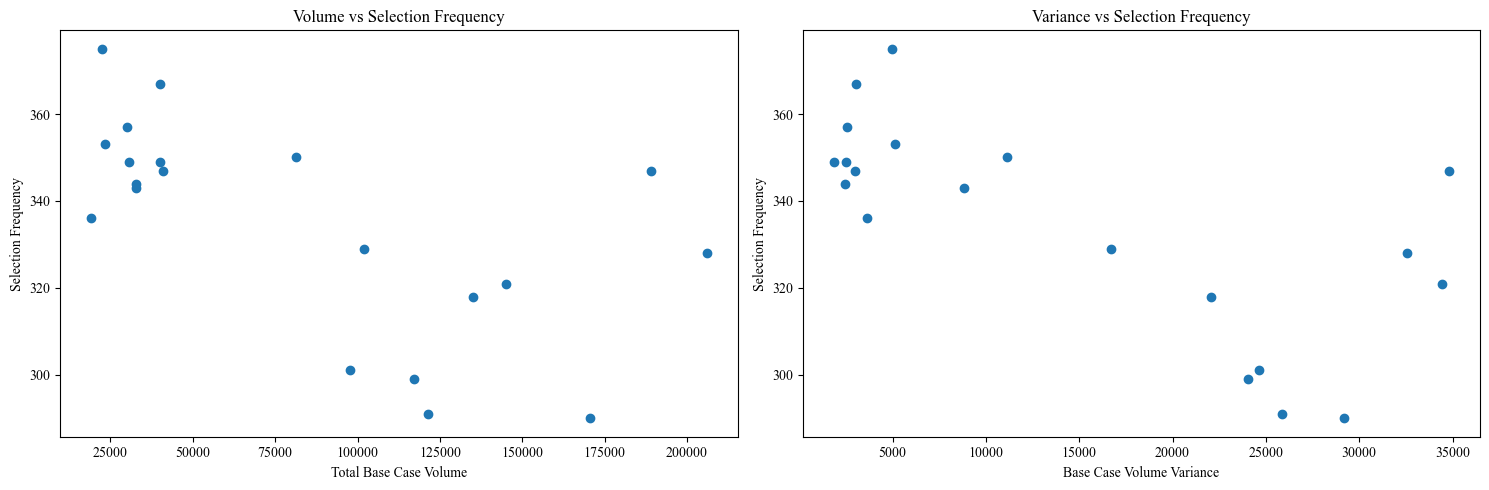

In [11]:
# Analyze district-level patterns
def analyze_district_selection_bias(gdf_inputs):
    """
    Analyze if districts with higher volumes/variances are selected more often.
    
    Parameters:
    -----------
    gdf_inputs : list of GeoDataFrames
        Each GDF should contain:
        - district information
        - vol_base_case (base volume)
        - capacity_reduction (to identify selected districts)
    
    Returns:
    --------
    dict with district statistics and selection patterns
    """
    # Get first GDF as reference for base case
    base_gdf = gdf_inputs[0].copy()
    
    # Calculate district-level statistics
    district_stats = {}
    
    # For each district
    for district in base_gdf['district'].unique():
        district_mask = base_gdf['district'] == district
        district_data = base_gdf[district_mask]
        
        # Calculate base case statistics
        mean_volume = district_data['vol_base_case'].mean()
        total_volume = district_data['vol_base_case'].sum()
        volume_variance = district_data['vol_base_case'].var()
        n_roads = len(district_data)
        
        # Count selections across scenarios
        selections = 0
        for gdf in gdf_inputs:
            district_data = gdf[gdf['district'] == district]
            # Count how often this district has capacity reductions
            has_reduction = (district_data['capacity_reduction'] < 0).any()
            if has_reduction:
                selections += 1
        
        district_stats[district] = {
            'mean_volume': mean_volume,
            'total_volume': total_volume,
            'volume_variance': volume_variance,
            'n_roads': n_roads,
            'selection_frequency': selections,
            'selection_probability': selections / len(gdf_inputs)
        }
    
    # Convert to DataFrame for easier analysis
    import pandas as pd
    df_stats = pd.DataFrame.from_dict(district_stats, orient='index')
    
    # Calculate correlations
    volume_selection_corr = df_stats['total_volume'].corr(df_stats['selection_frequency'])
    variance_selection_corr = df_stats['volume_variance'].corr(df_stats['selection_frequency'])
    
    # Sort districts by selection frequency
    df_stats_sorted = df_stats.sort_values('selection_frequency', ascending=False)
    
    return {
        'district_stats': df_stats_sorted,
        'correlations': {
            'volume_selection': volume_selection_corr,
            'variance_selection': variance_selection_corr
        }
    }

# Run the analysis
analysis = analyze_district_selection_bias(gdfs)

# Print results
print("\nDistrict Statistics (sorted by selection frequency):")
print(analysis['district_stats'])

print("\nCorrelations:")
print(f"Volume vs Selection Frequency: {analysis['correlations']['volume_selection']:.3f}")
print(f"Variance vs Selection Frequency: {analysis['correlations']['variance_selection']:.3f}")

# Plot relationships
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Volume vs Selection Frequency
ax1.scatter(analysis['district_stats']['total_volume'], 
           analysis['district_stats']['selection_frequency'])
ax1.set_xlabel('Total Base Case Volume')
ax1.set_ylabel('Selection Frequency')
ax1.set_title('Volume vs Selection Frequency')

# Variance vs Selection Frequency
ax2.scatter(analysis['district_stats']['volume_variance'], 
           analysis['district_stats']['selection_frequency'])
ax2.set_xlabel('Base Case Volume Variance')
ax2.set_ylabel('Selection Frequency')
ax2.set_title('Variance vs Selection Frequency')

plt.tight_layout()
plt.show()


District Statistics (sorted by total volume):
      mean_volume   total_volume  n_roads  selection_frequency  \
16.0    66.471596  205995.476190   3099.0                328.0   
12.0    75.539321  189226.000000   2505.0                347.0   
17.0    74.091642  170707.142857   2304.0                290.0   
14.0    82.980865  144967.571429   1747.0                321.0   
15.0    50.457157  135073.809524   2677.0                318.0   
13.0    51.577209  121515.904762   2356.0                291.0   
19.0    65.916834  117134.214286   1777.0                299.0   
18.0    49.322362  101900.000000   2066.0                329.0   
20.0    59.826870   97637.452381   1632.0                301.0   
8.0     63.110064   81285.761905   1288.0                350.0   
7.0     33.245639   41025.119048   1234.0                347.0   
10.0    39.501100   40172.619048   1017.0                367.0   
11.0    32.381705   39959.023810   1234.0                349.0   
5.0     37.291680   32891.261

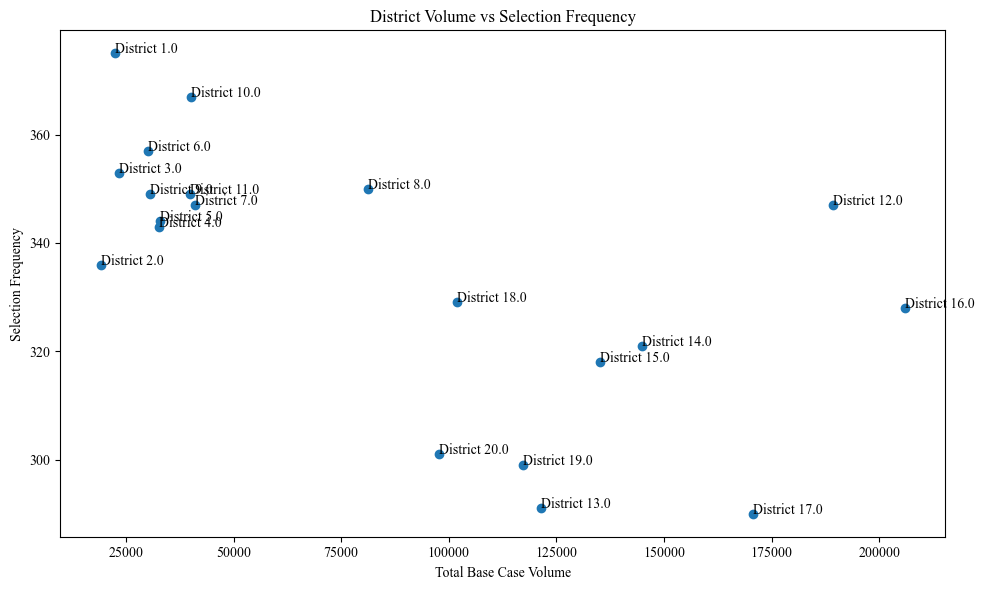

In [22]:
# Analyze district-level patterns focusing on volumes
def analyze_district_volume_bias(gdf_inputs):
    """
    Analyze if districts with higher volumes are selected more often.
    
    Parameters:
    -----------
    gdf_inputs : list of GeoDataFrames
        Each GDF should contain:
        - district information
        - vol_base_case (base volume)
        - capacity_reduction (to identify selected districts)
    
    Returns:
    --------
    dict with district statistics and selection patterns
    """
    # Get first GDF as reference for base case
    base_gdf = gdf_inputs[0].copy()
    
    # Calculate district-level statistics
    district_stats = {}
    
    # For each district
    for district in base_gdf['district'].unique():
        district_mask = base_gdf['district'] == district
        district_data = base_gdf[district_mask]
        
        # Calculate base case volume statistics
        mean_volume = district_data['vol_base_case'].mean()
        total_volume = district_data['vol_base_case'].sum()
        n_roads = len(district_data)
        
        # Count selections across scenarios
        selections = 0
        for gdf in gdf_inputs:
            district_data = gdf[gdf['district'] == district]
            # Count how often this district has capacity reductions
            has_reduction = (district_data['capacity_reduction'] < 0).any()
            if has_reduction:
                selections += 1
        
        district_stats[district] = {
            'mean_volume': mean_volume,
            'total_volume': total_volume,
            'n_roads': n_roads,
            'selection_frequency': selections,
            'selection_probability': selections / len(gdf_inputs)
        }
    
    # Convert to DataFrame for easier analysis
    import pandas as pd
    df_stats = pd.DataFrame.from_dict(district_stats, orient='index')
    
    # Calculate correlation
    volume_selection_corr = df_stats['total_volume'].corr(df_stats['selection_frequency'])
    
    # Sort districts by volume
    df_stats_sorted = df_stats.sort_values('total_volume', ascending=False)
    
    return {
        'district_stats': df_stats_sorted,
        'correlation': volume_selection_corr
    }

# Run the analysis
volume_analysis = analyze_district_volume_bias(gdfs)

# Print results
print("\nDistrict Statistics (sorted by total volume):")
print(volume_analysis['district_stats'])

print("\nCorrelation between Volume and Selection Frequency:", 
      f"{volume_analysis['correlation']:.3f}")

# Plot relationship
plt.figure(figsize=(10, 6))
plt.scatter(volume_analysis['district_stats']['total_volume'], 
           volume_analysis['district_stats']['selection_frequency'])
plt.xlabel('Total Base Case Volume')
plt.ylabel('Selection Frequency')
plt.title('District Volume vs Selection Frequency')

# Add district labels to points
for idx, row in volume_analysis['district_stats'].iterrows():
    plt.annotate(f"District {idx}", 
                (row['total_volume'], row['selection_frequency']))

plt.tight_layout()
plt.show()


District Volume Distribution Analysis:
           mean     median         std       q25        q75      skew  \
16.0  66.471596  15.857143  180.438463  2.952381  48.119048  5.114303   
12.0  75.539321  13.500000  186.601789  1.000000  51.023810  4.007638   
17.0  74.091642  18.595238  170.887693  1.845238  53.434524  4.198970   
14.0  82.980865  19.833333  185.621558  1.988095  69.583333  4.474157   
15.0  50.457157  17.690476  148.492372  2.000000  50.000000  7.126293   
13.0  51.577209  15.571429  160.881887  2.279762  48.434524  7.437948   
19.0  65.916834  18.238095  155.083799  2.928571  61.595238  5.095810   
18.0  49.322362   8.000000  129.183502  0.000000  39.238095  5.915119   
20.0  59.826870  13.630952  156.858033  2.994048  41.410714  4.922366   
8.0   63.110064  24.000000  105.504489  3.333333  63.220238  2.708480   
7.0   33.245639  13.321429   54.490520  1.160714  37.238095  3.123048   
10.0  39.501100  10.714286   55.247070  0.000000  58.023810  1.531582   
11.0  32.38

/tmp/ipykernel_3172479/1729163154.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selection_groups = district_volume_analysis.groupby('selection_quartile')


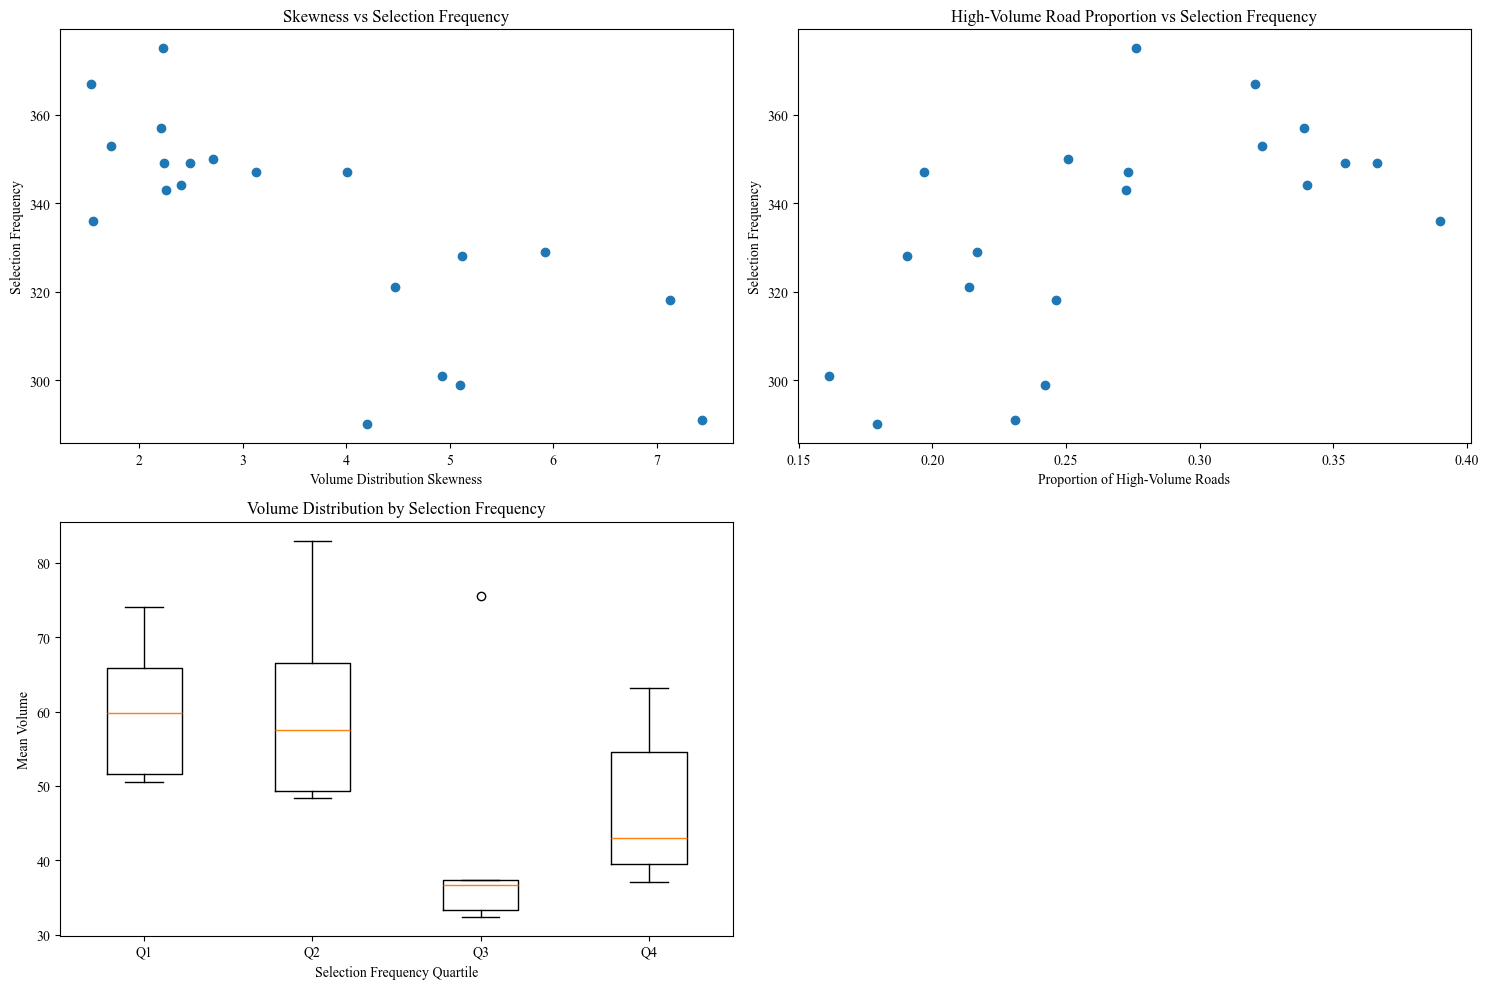


Summary of findings:

1. Volume distribution characteristics:
Mean skewness across districts: 3.64
Mean proportion of high-volume roads: 0.27

2. Correlations with selection frequency:
Skewness correlation: -0.762
High-volume proportion correlation: 0.605

3. Statistics by selection frequency quartile:
                     mean     std  skew  prop_high_volume
selection_quartile                                       
Q1                  60.37  158.44  5.76              0.21
Q2                  60.93  129.84  3.86              0.26
Q3                  43.01   76.67  2.85              0.31
Q4                  47.44   70.63  2.08              0.30


/tmp/ipykernel_3172479/1729163154.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = district_volume_analysis.groupby('selection_quartile').agg({


In [23]:
# Analyze volume distributions within districts
def analyze_within_district_volumes(gdf_inputs):
    """
    Analyze how volumes are distributed within each district.
    """
    # Get first GDF as reference for base case
    base_gdf = gdf_inputs[0].copy()
    
    # Calculate district-level statistics
    district_stats = {}
    
    # For each district
    for district in base_gdf['district'].unique():
        district_mask = base_gdf['district'] == district
        district_data = base_gdf[district_mask]
        
        # Calculate volume statistics
        volume_stats = {
            'mean': district_data['vol_base_case'].mean(),
            'median': district_data['vol_base_case'].median(),
            'std': district_data['vol_base_case'].std(),
            'q25': district_data['vol_base_case'].quantile(0.25),
            'q75': district_data['vol_base_case'].quantile(0.75),
            'skew': district_data['vol_base_case'].skew(),
            'n_roads': len(district_data),
            'n_high_volume': len(district_data[district_data['vol_base_case'] > district_data['vol_base_case'].mean()]),
            'total_volume': district_data['vol_base_case'].sum()
        }
        
        # Count selections across scenarios
        selections = 0
        for gdf in gdf_inputs:
            district_data = gdf[gdf['district'] == district]
            has_reduction = (district_data['capacity_reduction'] < 0).any()
            if has_reduction:
                selections += 1
        
        volume_stats['selection_frequency'] = selections
        district_stats[district] = volume_stats
    
    # Convert to DataFrame
    df_stats = pd.DataFrame.from_dict(district_stats, orient='index')
    
    # Sort by total volume
    df_stats_sorted = df_stats.sort_values('total_volume', ascending=False)
    
    # Calculate proportion of high-volume roads
    df_stats_sorted['prop_high_volume'] = df_stats_sorted['n_high_volume'] / df_stats_sorted['n_roads']
    
    return df_stats_sorted

# Run the analysis
district_volume_analysis = analyze_within_district_volumes(gdfs)

print("\nDistrict Volume Distribution Analysis:")
print(district_volume_analysis)

# Create visualization of volume distributions
plt.figure(figsize=(15, 10))

# Plot 1: Distribution skewness vs selection frequency
plt.subplot(2, 2, 1)
plt.scatter(district_volume_analysis['skew'], 
           district_volume_analysis['selection_frequency'])
plt.xlabel('Volume Distribution Skewness')
plt.ylabel('Selection Frequency')
plt.title('Skewness vs Selection Frequency')

# Plot 2: Proportion of high-volume roads vs selection frequency
plt.subplot(2, 2, 2)
plt.scatter(district_volume_analysis['prop_high_volume'], 
           district_volume_analysis['selection_frequency'])
plt.xlabel('Proportion of High-Volume Roads')
plt.ylabel('Selection Frequency')
plt.title('High-Volume Road Proportion vs Selection Frequency')

# Plot 3: Box plot of volume distributions by selection frequency quartile
plt.subplot(2, 2, 3)
district_volume_analysis['selection_quartile'] = pd.qcut(district_volume_analysis['selection_frequency'], 
                                                       q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
selection_groups = district_volume_analysis.groupby('selection_quartile')
box_data = [group['mean'] for name, group in selection_groups]
plt.boxplot(box_data, labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.xlabel('Selection Frequency Quartile')
plt.ylabel('Mean Volume')
plt.title('Volume Distribution by Selection Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of findings:")
print("\n1. Volume distribution characteristics:")
print(f"Mean skewness across districts: {district_volume_analysis['skew'].mean():.2f}")
print(f"Mean proportion of high-volume roads: {district_volume_analysis['prop_high_volume'].mean():.2f}")

print("\n2. Correlations with selection frequency:")
print(f"Skewness correlation: {district_volume_analysis['skew'].corr(district_volume_analysis['selection_frequency']):.3f}")
print(f"High-volume proportion correlation: {district_volume_analysis['prop_high_volume'].corr(district_volume_analysis['selection_frequency']):.3f}")

# Group districts by selection frequency quartile and analyze volume patterns
quartile_stats = district_volume_analysis.groupby('selection_quartile').agg({
    'mean': 'mean',
    'std': 'mean',
    'skew': 'mean',
    'prop_high_volume': 'mean'
}).round(2)

print("\n3. Statistics by selection frequency quartile:")
print(quartile_stats)

In [12]:
def analyze_district_volumes(gdf_inputs):
    """
    Analyze volume distribution across districts with robust nan handling.
    
    Parameters:
    -----------
    gdf_inputs : list of GeoDataFrames
        Each GDF should contain:
        - district information
        - vol_base_case (base volume)
        - capacity_reduction (to identify selected districts)
    
    Returns:
    --------
    dict with district statistics
    """
    if not gdf_inputs or len(gdf_inputs) == 0:
        raise ValueError("Empty input list provided")

    # Get first GDF as reference
    base_gdf = gdf_inputs[0].copy()
    
    # Validate required columns
    required_columns = ['district', 'vol_base_case', 'capacity_reduction']
    if not all(col in base_gdf.columns for col in required_columns):
        raise ValueError(f"Missing required columns. Expected: {required_columns}")
    
    # Calculate district statistics
    district_stats = {}
    
    # For each district
    for district in base_gdf['district'].unique():
        if pd.isna(district):  # Skip if district is nan
            continue
            
        district_mask = base_gdf['district'] == district
        district_data = base_gdf[district_mask]
        
        # Calculate mean volume with nan handling
        volumes = district_data['vol_base_case'].dropna()
        if len(volumes) == 0:
            mean_volume = np.nan
        else:
            mean_volume = volumes.mean()
        
        # Count edges (excluding nan values)
        n_edges = len(district_data.dropna(subset=['vol_base_case']))
        
        # Count selections across all scenarios
        selections = 0
        for gdf in gdf_inputs:
            if 'district' not in gdf.columns or 'capacity_reduction' not in gdf.columns:
                continue
                
            district_data = gdf[gdf['district'] == district]
            # Count how often this district has capacity reductions, handling nans
            capacity_reductions = district_data['capacity_reduction'].dropna()
            if len(capacity_reductions) > 0 and (capacity_reductions < 0).any():
                selections += 1
        
        district_stats[district] = {
            'mean_volume': mean_volume,
            'n_edges': n_edges,
            'selection_frequency': selections
        }
    
    # Calculate overall statistics, excluding nan values
    valid_volumes = [stats['mean_volume'] for stats in district_stats.values() 
                    if not np.isnan(stats['mean_volume'])]
    
    if not valid_volumes:
        return {
            'district_stats': district_stats,
            'mean_volume': np.nan,
            'std_volume': np.nan,
            'threshold': np.nan,
            'high_volume_districts': {}
        }
    
    mean_volume = np.mean(valid_volumes)
    std_volume = np.std(valid_volumes)
    threshold = mean_volume + std_volume
    
    # Identify high-volume districts, excluding nan values
    high_volume_districts = {
        d: stats for d, stats in district_stats.items() 
        if not np.isnan(stats['mean_volume']) and stats['mean_volume'] > threshold
    }
    
    return {
        'district_stats': district_stats,
        'mean_volume': mean_volume,
        'std_volume': std_volume,
        'threshold': threshold,
        'high_volume_districts': high_volume_districts
    }

# Example usage:
stats = analyze_district_volumes(gdfs)
print(f"Mean volume across districts: {stats['mean_volume']:.2f}")
print(f"Standard deviation: {stats['std_volume']:.2f}")
print(f"Threshold for high-volume: {stats['threshold']:.2f}")
print("\nHigh-volume districts:")
for district, data in stats['high_volume_districts'].items():
    print(f"District {district}:")
    print(f"  Mean volume: {data['mean_volume']:.2f}")
    print(f"  Number of edges: {data['n_edges']}")
    print(f"  Selection frequency: {data['selection_frequency']}")

Mean volume across districts: 52.94
Standard deviation: 14.64
Threshold for high-volume: 67.57

High-volume districts:
District 17.0:
  Mean volume: 74.09
  Number of edges: 2304
  Selection frequency: 290
District 12.0:
  Mean volume: 75.54
  Number of edges: 2505
  Selection frequency: 347
District 14.0:
  Mean volume: 82.98
  Number of edges: 1747
  Selection frequency: 321



Correlation between Volume and Variance: 0.952


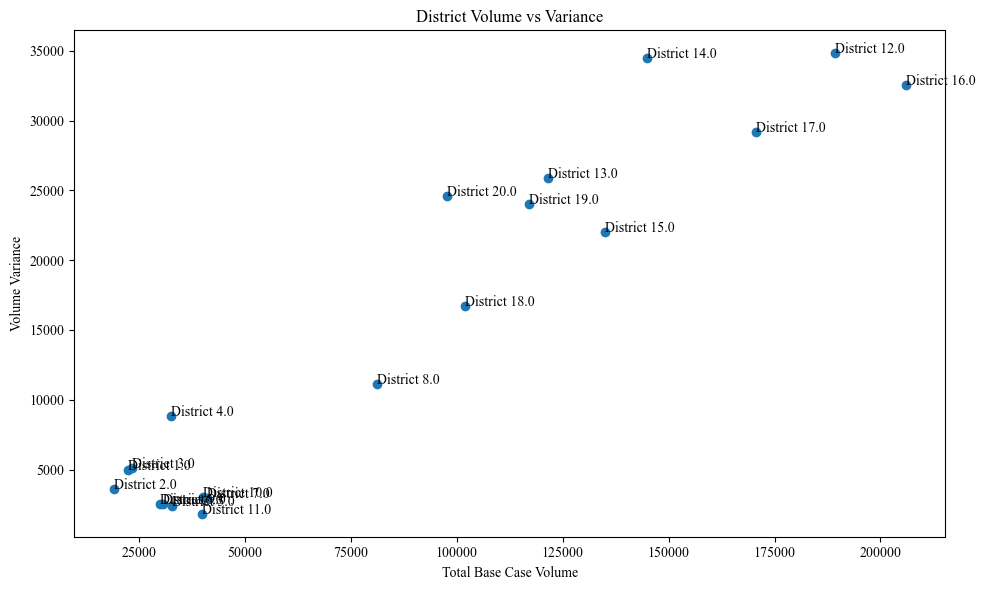

In [13]:
# Calculate correlation between volume and variance
volume_variance_corr = analysis['district_stats']['total_volume'].corr(analysis['district_stats']['volume_variance'])
print("\nCorrelation between Volume and Variance:", f"{volume_variance_corr:.3f}")

# Create scatter plot of volume vs variance
plt.figure(figsize=(10, 6))
plt.scatter(analysis['district_stats']['total_volume'], 
           analysis['district_stats']['volume_variance'])
plt.xlabel('Total Base Case Volume')
plt.ylabel('Volume Variance')
plt.title('District Volume vs Variance')

# Add district labels to points
for idx, row in analysis['district_stats'].iterrows():
    plt.annotate(f"District {idx}", 
                (row['total_volume'], row['volume_variance']))

plt.tight_layout()
plt.show()

KeyError: 'district_stats'

In [ ]:
fasdf

In [14]:
def analyze_volumes_by_capacity_reduction(gdf):
    """
    Compare volumes between roads with and without capacity reduction.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Should contain:
        - vol_base_case (base volume)
        - capacity_reduction
    
    Returns:
    --------
    dict with comparison statistics
    """
    # Create masks for roads with and without capacity reduction
    has_reduction = gdf['capacity_reduction'] < 0
    no_reduction = gdf['capacity_reduction'] >= 0
    
    # Calculate statistics for each group
    reduced_stats = {
        'mean_volume': gdf[has_reduction]['vol_base_case'].mean(),
        'std_volume': gdf[has_reduction]['vol_base_case'].std(),
        'count': has_reduction.sum()
    }
    
    normal_stats = {
        'mean_volume': gdf[no_reduction]['vol_base_case'].mean(),
        'std_volume': gdf[no_reduction]['vol_base_case'].std(),
        'count': no_reduction.sum()
    }
    
    return {
        'with_reduction': reduced_stats,
        'without_reduction': normal_stats
    }

# Example usage:
comparison = analyze_volumes_by_capacity_reduction(gdfs[0])
print("\nComparison of roads with and without capacity reduction:")
print("\nRoads WITH capacity reduction:")
print(f"  Mean volume: {comparison['with_reduction']['mean_volume']:.2f}")
print(f"  Std volume: {comparison['with_reduction']['std_volume']:.2f}")
print(f"  Count: {comparison['with_reduction']['count']}")
print("\nRoads WITHOUT capacity reduction:")
print(f"  Mean volume: {comparison['without_reduction']['mean_volume']:.2f}")
print(f"  Std volume: {comparison['without_reduction']['std_volume']:.2f}")
print(f"  Count: {comparison['without_reduction']['count']}")


Comparison of roads with and without capacity reduction:

Roads WITH capacity reduction:
  Mean volume: 86.87
  Std volume: 98.24
  Count: 3029

Roads WITHOUT capacity reduction:
  Mean volume: 47.80
  Std volume: 139.22
  Count: 29757


In [15]:
def perform_statistical_analysis(gdf):
    """
    Perform comprehensive statistical analysis comparing roads with and without capacity reduction.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Should contain:
        - vol_base_case (base volume)
        - capacity_reduction
    
    Returns:
    --------
    dict with detailed statistical analysis
    """
    import scipy.stats as stats
    import numpy as np
    
    # Create masks for roads with and without capacity reduction
    has_reduction = gdf['capacity_reduction'] < 0
    no_reduction = gdf['capacity_reduction'] >= 0
    
    # Get volumes for each group
    volumes_reduced = gdf[has_reduction]['vol_base_case'].dropna()
    volumes_normal = gdf[no_reduction]['vol_base_case'].dropna()
    
    # Basic statistics
    stats_reduced = {
        'count': len(volumes_reduced),
        'mean': volumes_reduced.mean(),
        'median': volumes_reduced.median(),
        'std': volumes_reduced.std(),
        'q25': volumes_reduced.quantile(0.25),
        'q75': volumes_reduced.quantile(0.75),
        'skew': stats.skew(volumes_reduced),
        'kurtosis': stats.kurtosis(volumes_reduced)
    }
    
    stats_normal = {
        'count': len(volumes_normal),
        'mean': volumes_normal.mean(),
        'median': volumes_normal.median(),
        'std': volumes_normal.std(),
        'q25': volumes_normal.quantile(0.25),
        'q75': volumes_normal.quantile(0.75),
        'skew': stats.skew(volumes_normal),
        'kurtosis': stats.kurtosis(volumes_normal)
    }
    
    # Perform Mann-Whitney U test (non-parametric test for different distributions)
    mw_stat, mw_pval = stats.mannwhitneyu(volumes_reduced, volumes_normal, alternative='two-sided')
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((stats_reduced['count'] - 1) * stats_reduced['std']**2 + 
                         (stats_normal['count'] - 1) * stats_normal['std']**2) / 
                        (stats_reduced['count'] + stats_normal['count'] - 2))
    cohens_d = (stats_reduced['mean'] - stats_normal['mean']) / pooled_std
    
    return {
        'with_reduction': stats_reduced,
        'without_reduction': stats_normal,
        'mann_whitney': {
            'statistic': mw_stat,
            'p_value': mw_pval
        },
        'cohens_d': cohens_d
    }

# Run the analysis
analysis = perform_statistical_analysis(gdfs[0])

# Print results
print("\nDetailed Statistical Analysis:")
print("\nRoads WITH capacity reduction:")
print(f"  Count: {analysis['with_reduction']['count']}")
print(f"  Mean: {analysis['with_reduction']['mean']:.2f}")
print(f"  Median: {analysis['with_reduction']['median']:.2f}")
print(f"  Std Dev: {analysis['with_reduction']['std']:.2f}")
print(f"  Q25-Q75: [{analysis['with_reduction']['q25']:.2f} - {analysis['with_reduction']['q75']:.2f}]")
print(f"  Skewness: {analysis['with_reduction']['skew']:.2f}")

print("\nRoads WITHOUT capacity reduction:")
print(f"  Count: {analysis['without_reduction']['count']}")
print(f"  Mean: {analysis['without_reduction']['mean']:.2f}")
print(f"  Median: {analysis['without_reduction']['median']:.2f}")
print(f"  Std Dev: {analysis['without_reduction']['std']:.2f}")
print(f"  Q25-Q75: [{analysis['without_reduction']['q25']:.2f} - {analysis['without_reduction']['q75']:.2f}]")
print(f"  Skewness: {analysis['without_reduction']['skew']:.2f}")

print("\nStatistical Tests:")
print(f"  Mann-Whitney U p-value: {analysis['mann_whitney']['p_value']:.10f}")
print(f"  Effect size (Cohen's d): {analysis['cohens_d']:.2f}")

# Print interpretation
print("\nInterpretation:")
print("1. Statistical Significance:")
if analysis['mann_whitney']['p_value'] < 0.05:
    print("  - The difference in volumes is statistically significant (p < 0.05)")
else:
    print("  - The difference in volumes is not statistically significant (p >= 0.05)")

print("\n2. Effect Size Interpretation:")
d = abs(analysis['cohens_d'])
if d < 0.2:
    effect = "negligible"
elif d < 0.5:
    effect = "small"
elif d < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"  - Cohen's d = {d:.2f} indicates a {effect} effect size")


Detailed Statistical Analysis:

Roads WITH capacity reduction:
  Count: 3029
  Mean: 86.87
  Median: 55.19
  Std Dev: 98.24
  Q25-Q75: [27.88 - 103.67]
  Skewness: 2.48

Roads WITHOUT capacity reduction:
  Count: 29757
  Mean: 47.80
  Median: 8.00
  Std Dev: 139.22
  Q25-Q75: [0.00 - 38.05]
  Skewness: 6.35

Statistical Tests:
  Mann-Whitney U p-value: 0.0000000000
  Effect size (Cohen's d): 0.29

Interpretation:
1. Statistical Significance:
  - The difference in volumes is statistically significant (p < 0.05)

2. Effect Size Interpretation:
  - Cohen's d = 0.29 indicates a small effect size


In [16]:
# def validate_model_with_interpretable_error(indices, gdfs):
#     """
#     Validate model performance across all test set observations for specific road types.
    
#     Args:
#         indices: Indices of roads to consider for each GDF
#         gdfs: List of GeoDataFrames, each representing one test set observation
#     """
#     loss_fct_l1 = torch.nn.L1Loss()
#     loss_fct_l2 = torch.nn.MSELoss()
    
#     # Initialize lists to store values across all observations
#     all_actual_vals = []
#     all_predicted_vals = []
#     mean_car_vols = []
#     variances_base_case = []
#     variances = []
#     std_devs = []
#     std_dev_multiplied = []
#     cv_percents = []
    
#     # Collect values from all GDFs
#     i = 0
#     for gdf in gdfs:
#         indices = hf.get_road_type_indices(gdf)[road_type]
        
#         if len(indices) > 0:  # Only process if we have roads of this type
#             i += 1
#             actual_vals = gdf.loc[indices, 'vol_car_change_actual']
#             predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
            
#             all_actual_vals.extend(actual_vals.to_numpy())
#             all_predicted_vals.extend(predicted_vals.to_numpy())
            
#             # Collect statistics
#             mean_car_vols.append(gdf.loc[indices, 'vol_base_case'].mean())
            
#             car_volumes = actual_vals.to_numpy()
#             car_volume_variance = np.var(car_volumes)
            
#             variances.append(car_volume_variance)
            
#             variances_base_case.append(gdf.loc[indices, 'variance_base_case'].mean())
#             std_devs.append(gdf.loc[indices, 'std_dev'].mean())
#             std_dev_multiplied.append(gdf.loc[indices, 'std_dev_multiplied'].mean())
#             cv_percents.append(gdf.loc[indices, 'cv_percent'].mean())
    
#     # Convert to numpy arrays
#     all_actual_vals = np.array(all_actual_vals)
#     all_predicted_vals = np.array(all_predicted_vals)
    
#     actual_mean = torch.mean(torch.tensor(all_actual_vals))
    
#     # Calculate metrics
#     spearman_corr, pearson_corr = hf.compute_correlations_scipy(all_predicted_vals, all_actual_vals)    
#     r_squared = hf.compute_r2_torch(preds=torch.tensor(all_predicted_vals), targets=torch.tensor(all_actual_vals))
    
#     l1_loss = loss_fct_l1(torch.tensor(all_actual_vals), torch.tensor(all_predicted_vals))
#     l2_loss = loss_fct_l2(torch.tensor(all_actual_vals), torch.tensor(all_predicted_vals))
    
#     l1_naive = loss_fct_l1(torch.tensor(all_actual_vals), torch.full_like(torch.tensor(all_actual_vals), actual_mean))    
#     l2_naive = loss_fct_l2(torch.tensor(all_actual_vals), torch.full_like(torch.tensor(all_actual_vals), actual_mean))
    
#     # Calculate averages of statistics
#     mean_car_vol = np.mean(mean_car_vols)
#     variance = np.mean(variances)
#     variance_base_case = np.mean(variances_base_case)
#     std_dev = np.mean(std_devs)
#     std_dev_multiplied = np.mean(std_dev_multiplied)
#     cv_percent = np.mean(cv_percents)
    
#     print(" ")
#     print(f"Road Type: {road_type}")
#     print(f"Number of observations: {len(all_actual_vals)/416}")
#     print(f"Mean Car Volume: {mean_car_vol}")
#     print(f"R-squared: {round(r_squared.item(), 2)}")
#     print(f"MSE Loss: {l2_loss}")
#     print(f"Naive MSE Loss: {l2_naive}")
#     print(f"Variance Base Case: {variance_base_case}")
    
    
#     # print(f"Variance over car volumes: {car_volume_variance}")
#     print(f"Variance: {variance}")
#     print(f"L1 Loss: {l1_loss}")
#     print(f"Naive L1 loss: {l1_naive}")
#     print(f"Standard Deviation Multiplied: {std_dev_multiplied}")
#     print(f"Spearman Correlation: {spearman_corr}")
#     print(f"Pearson Correlation: {pearson_corr}")
#     print(f"Standard Deviation: {std_dev}")
#     print(f"Coefficient of Variation: {cv_percent}")
#     print(" ")
    
#     return {
#         'road_type': road_type,
#         'number_of_observations': len(all_actual_vals),
#         'mean_car_vol': mean_car_vol,
#         'r_squared': r_squared,
#         'mse': l2_loss,
#         'naive_mse': l2_naive,
#         'l1': l1_loss,
#         'naive_l1': l1_naive,
#         'variance': variance_base_case,
#         'std_dev': std_dev,
#         'std_dev_normalized': std_dev_multiplied,
#         'spearman': spearman_corr,
#         'pearson': pearson_corr,
#         'cv_percent': cv_percent
#     }

# road_types = list(hf.get_road_type_indices(gdfs[0]).keys())

# # Then calculate metrics for each road type
# metrics_by_type = {}
# for road_type in road_types:
#     metrics_by_type[road_type] = validate_model_with_interpretable_error(road_type, gdfs)

In [17]:
# def analyze_variances_by_capacity_reduction_pst(gdfs):
#     # Initialize lists to store values
#     with_reduction = {'actual_changes': [], 'predictions': [], 'errors': []}
#     without_reduction = {'actual_changes': [], 'predictions': [], 'errors': []}
    
#     # Collect values from all GDFs
#     for gdf in gdfs:
#         # Only consider Primary, Secondary, Tertiary roads (highway values 1, 2, 3)
#         pst_mask = gdf['highway'].isin([1, 2, 3])
        
#         # Roads with capacity reduction
#         reduced = (gdf['capacity_reduction_rounded'] < -1e-3) & pst_mask
#         with_reduction['actual_changes'].extend(gdf.loc[reduced, 'vol_car_change_actual'])
#         with_reduction['predictions'].extend(gdf.loc[reduced, 'vol_car_change_predicted'])
#         with_reduction['errors'].extend(
#             gdf.loc[reduced, 'vol_car_change_predicted'] - gdf.loc[reduced, 'vol_car_change_actual']
#         )
        
#         # Roads without capacity reduction
#         not_reduced = (gdf['capacity_reduction_rounded'] >= -1e-3) & pst_mask
#         without_reduction['actual_changes'].extend(gdf.loc[not_reduced, 'vol_car_change_actual'])
#         without_reduction['predictions'].extend(gdf.loc[not_reduced, 'vol_car_change_predicted'])
#         without_reduction['errors'].extend(
#             gdf.loc[not_reduced, 'vol_car_change_predicted'] - gdf.loc[not_reduced, 'vol_car_change_actual']
#         )
    
#     # Convert to numpy arrays for easier calculation
#     for key in ['actual_changes', 'predictions', 'errors']:
#         with_reduction[key] = np.array(with_reduction[key])
#         without_reduction[key] = np.array(without_reduction[key])
    
#     # Print statistics
#     print("PST Roads WITH capacity reduction:")
#     print(f"Number of observations: {len(with_reduction['actual_changes'])}")
#     print(f"Variance of actual changes: {np.var(with_reduction['actual_changes']):.2f}")
#     print(f"Mean absolute error: {np.mean(np.abs(with_reduction['errors'])):.2f}")
#     print(f"MSE: {np.mean(with_reduction['errors']**2):.2f}")
#     print(f"Mean actual change: {np.mean(with_reduction['actual_changes']):.2f}")
#     print(f"Std of actual changes: {np.std(with_reduction['actual_changes']):.2f}")
#     print(f"R² score: {1 - np.mean(with_reduction['errors']**2)/np.var(with_reduction['actual_changes']):.3f}")
#     print("\n")
    
#     print("PST Roads WITHOUT capacity reduction:")
#     print(f"Number of observations: {len(without_reduction['actual_changes'])}")
#     print(f"Variance of actual changes: {np.var(without_reduction['actual_changes']):.2f}")
#     print(f"Mean absolute error: {np.mean(np.abs(without_reduction['errors'])):.2f}")
#     print(f"MSE: {np.mean(without_reduction['errors']**2):.2f}")
#     print(f"Mean actual change: {np.mean(without_reduction['actual_changes']):.2f}")
#     print(f"Std of actual changes: {np.std(without_reduction['actual_changes']):.2f}")
#     print(f"R² score: {1 - np.mean(without_reduction['errors']**2)/np.var(without_reduction['actual_changes']):.3f}")

# analyze_variances_by_capacity_reduction_pst(gdfs)

In [18]:
def analyze_variances_by_road_type_and_reduction(gdfs):
    # Initialize dictionaries for each road type
    road_types = {
        1: "Primary",
        2: "Secondary",
        3: "Tertiary"
    }
    
    stats = {road_type: {
        'with_reduction': {'actual_changes': [], 'predictions': [], 'errors': []},
        'without_reduction': {'actual_changes': [], 'predictions': [], 'errors': []}
    } for road_type in road_types.keys()}
    
    # Collect values from all GDFs
    for gdf in gdfs:
        for road_type in road_types.keys():
            # Filter for specific road type
            road_type_mask = gdf['highway'] == road_type
            
            # Roads with capacity reduction
            reduced = (gdf['capacity_reduction_rounded'] < -1e-3) & road_type_mask
            stats[road_type]['with_reduction']['actual_changes'].extend(gdf.loc[reduced, 'vol_car_change_actual'])
            stats[road_type]['with_reduction']['predictions'].extend(gdf.loc[reduced, 'vol_car_change_predicted'])
            stats[road_type]['with_reduction']['errors'].extend(
                gdf.loc[reduced, 'vol_car_change_predicted'] - gdf.loc[reduced, 'vol_car_change_actual']
            )
            
            # Roads without capacity reduction
            not_reduced = (gdf['capacity_reduction_rounded'] >= -1e-3) & road_type_mask
            stats[road_type]['without_reduction']['actual_changes'].extend(gdf.loc[not_reduced, 'vol_car_change_actual'])
            stats[road_type]['without_reduction']['predictions'].extend(gdf.loc[not_reduced, 'vol_car_change_predicted'])
            stats[road_type]['without_reduction']['errors'].extend(
                gdf.loc[not_reduced, 'vol_car_change_predicted'] - gdf.loc[not_reduced, 'vol_car_change_actual']
            )
    
    # Calculate and print statistics for each road type
    for road_type in road_types.keys():
        print(f"\n{road_types[road_type]} Roads:")
        print("-" * 50)
        
        for reduction_type in ['with_reduction', 'without_reduction']:
            # Convert to numpy arrays
            actual = np.array(stats[road_type][reduction_type]['actual_changes'])
            errors = np.array(stats[road_type][reduction_type]['errors'])
            
            if len(actual) > 0:  # Only print if we have data
                print(f"\n{reduction_type.replace('_', ' ').title()}:")
                print(f"Number of observations: {len(actual)}")
                print(f"Variance of actual changes: {np.var(actual):.2f}")
                print(f"Mean absolute error: {np.mean(np.abs(errors)):.2f}")
                print(f"MSE: {np.mean(errors**2):.2f}")
                print(f"Mean actual change: {np.mean(actual):.2f}")
                print(f"Std of actual changes: {np.std(actual):.2f}")
                print(f"R² score: {1 - np.mean(errors**2)/np.var(actual):.3f}")

analyze_variances_by_road_type_and_reduction(gdfs)


Primary Roads:
--------------------------------------------------

With Reduction:
Number of observations: 594435
Variance of actual changes: 1250.88
Mean absolute error: 5.47
MSE: 61.28
Mean actual change: -10.02
Std of actual changes: 35.37
R² score: 0.951

Without Reduction:
Number of observations: 1721021
Variance of actual changes: 90.63
Mean absolute error: 4.45
MSE: 55.09
Mean actual change: 0.76
Std of actual changes: 9.52
R² score: 0.392

Secondary Roads:
--------------------------------------------------

With Reduction:
Number of observations: 430234
Variance of actual changes: 208.84
Mean absolute error: 4.21
MSE: 32.42
Mean actual change: -1.50
Std of actual changes: 14.45
R² score: 0.845

Without Reduction:
Number of observations: 1423878
Variance of actual changes: 42.01
Mean absolute error: 3.24
MSE: 27.59
Mean actual change: 1.11
Std of actual changes: 6.48
R² score: 0.343

Tertiary Roads:
--------------------------------------------------

With Reduction:
Number of o

In [19]:
# selected_metrics = [
#             {
#             'id': 'spearman',
#             'label': 'Spearman\nCorrelation',
#             'transform': lambda x: max(0, x),
#             'y_pos': -0.05
#             },
#             {
#                 'id': 'r_squared',
#                 'label': 'R²',
#                 'transform': lambda x: max(0, x),
#                 'y_pos': -0.05
#             },
#             {
#                 'id': 'l1_ratio',
#                 'label': 'Normalized MAE',
#                 'transform': lambda x, max_ratio: (1 - x/max_ratio),
#                 'y_pos': -0.1
#             },
#             {
#                 'id': 'pearson',
#                 'label': 'Pearson\nCorrelation',
#                 'transform': lambda x: max(0, x),
#                 'y_pos': -0.05
#             }
#         ]

# # selected_metrics = [
# #     {
# #         'id': 'r_squared',
# #         'label': 'R²',
# #         'transform': lambda x: max(0, x),
# #         'y_pos': -0.05
# #     },
# #     {
# #         'id': 'l1_ratio',
# #         'label': '1 - MAE/Naive MAE',
# #         'transform': lambda x, max_ratio: (1 - x/max_ratio),
# #         'y_pos': -0.1
# #     },
# #     {
# #         'id': 'pearson',
# #         'label': 'Pearson\nCorrelation',
# #         'transform': lambda x: max(0, x),
# #         'y_pos': -0.05
# #     },
# #     {
# #         'id': 'spearman',
# #         'label': 'Spearman\nCorrelation',
# #         'transform': lambda x: max(0, x),
# #         'y_pos': -0.05
# #     },
# #     # {
# #     #     'id': 'error_distribution',
# #     #     'label': 'Error\nDistribution',
# #     #     'transform': lambda x: max(0, (x - 68) / (100 - 68)),  # Normalize relative to normal distribution baseline
# #     #     'y_pos': -0.05
# #     # }
# # ]
# colors = {
#     'Trunk Roads': '#d73027',         # Red
#     'Primary Roads': '#fc8d59',       # Orange
#     'Secondary Roads': '#fee090',     # Yellow
#     'Tertiary Roads': '#e0f3f8',      # Light blue
#     'Residential Streets': '#91bfdb',  # Medium blue
#     'Living Streets': '#4575b4',      # Dark blue
#     'P/S/T Roads with Capacity Reduction': '#999999',    
#     'P/S/T Roads with No Capacity Reduction': '#666666',
# }


# # Define selected road types
# selected_types = [
#     # 'All Roads',
#     'Trunk Roads',
#     'Primary Roads',
#     'Secondary Roads',
#     'Tertiary Roads',
#     'Residential Streets',
#     'Living Streets',
#     'P/S/T Roads with Capacity Reduction',
#     'P/S/T Roads with No Capacity Reduction'
#     # 'Primary Roads with Capacity Reduction',
#     # 'Primary Roads with No Capacity Reduction',
#     # 'Secondary Roads with Capacity Reduction',
#     # 'Secondary Roads with No Capacity Reduction',
#     # 'Tertiary Roads with Capacity Reduction',
#     # 'Tertiary Roads with No Capacity Reduction'
# ]

# hf.create_correlation_radar_plot_sort_by_r2(metrics_by_type, selected_metrics, result_path=result_path, save_it=True, selected_types=selected_types, colors=colors)

In [20]:
# Add to your notebook to investigate the distribution of errors
def analyze_error_distribution(metrics_by_type):
    road_type = "All roads"
    gdf_data = gdfs[0]  # Get first GDF for "All roads"
    
    actual = gdf_data['vol_car_change_actual']
    predicted = gdf_data['vol_car_change_predicted']
    
    # Calculate errors
    errors = predicted - actual
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50)
    plt.title("Distribution of Prediction Errors for All Roads")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.show()
    
    # Print statistics
    print(f"Error Statistics for {road_type}:")
    print(f"Mean error: {errors.mean():.2f}")
    print(f"Median error: {errors.median():.2f}")
    print(f"Standard deviation of errors: {errors.std():.2f}")
    print(f"Percentage of errors within ±1 std: {(abs(errors) <= errors.std()).mean()*100:.1f}%")
    
analyze_error_distribution(metrics_by_type)

NameError: name 'metrics_by_type' is not defined

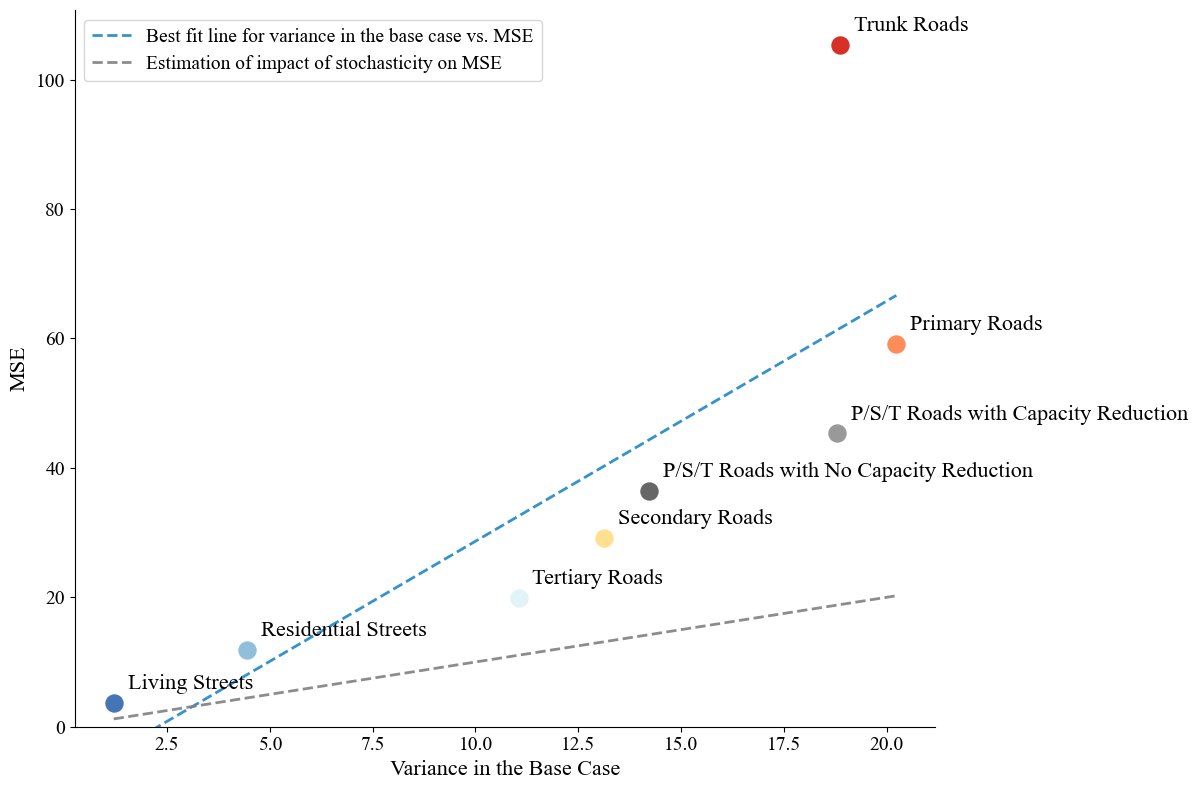

In [16]:
# hf.create_error_vs_variability_scatterplots(metrics_by_type, result_path=result_path, save_it=True, selected_types=selected_types, colors=colors)

In [17]:
hf.create_error_vs_variability_scatterplots_mse_and_mae(metrics_by_type, result_path=result_path, save_it=False)